In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

data = pd.read_csv("train.csv", sep=",")

print(data.head())
print(data.info(verbose=True))

   Unnamed: 0      id  Gender      Customer Type  Age   Type of Travel  \
0           0   70172    Male     Loyal Customer   13  Personal Travel   
1           1    5047    Male  disloyal Customer   25  Business travel   
2           2  110028  Female     Loyal Customer   26  Business travel   
3           3   24026  Female     Loyal Customer   25  Business travel   
4           4  119299    Male     Loyal Customer   61  Business travel   

      Class  Flight Distance  Inflight wifi service  \
0  Eco Plus              460                      3   
1  Business              235                      3   
2  Business             1142                      2   
3  Business              562                      2   
4  Business              214                      3   

   Departure/Arrival time convenient  ...  Inflight entertainment  \
0                                  4  ...                       5   
1                                  2  ...                       1   
2                

In [31]:
# Вывод выборочных данных
print(data['Gender'].value_counts(), '\n')
print(data['Customer Type'].value_counts(), '\n')
print(data['Type of Travel'].value_counts(), '\n')
print(data['Class'].value_counts(), '\n')
print(data['satisfaction'].value_counts(), '\n')

print('Number of missing data for Inflight wifi service', (data['Inflight wifi service'] == 0).sum())
print('Number of available data for Inflight wifi service', (data['Inflight wifi service'] != 0).sum())

# Фильтрация
data = data[data['Inflight wifi service'] != 0]
data = data[data['Class'] != 'Eco Plus']

# Сохраняем ID
ids = data['id']

# Кодирование категориальных
data['Gender'] = data['Gender'].map({'Female': 0, 'Male': 1})
data['Customer Type'] = data['Customer Type'].map({'Loyal Customer': 0, 'disloyal Customer': 1})
data['Type of Travel'] = data['Type of Travel'].map({'Business travel': 0, 'Personal Travel': 1})
data['Class'] = data['Class'].map({'Business': 0, 'Eco': 1})
data['satisfaction'] = data['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})

# Удаляем мусорные колонки
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

# Убираем id только из признаков
features = data.drop('id', axis=1)

Gender
Female    52727
Male      51177
Name: count, dtype: int64 

Customer Type
Loyal Customer       84923
disloyal Customer    18981
Name: count, dtype: int64 

Type of Travel
Business travel    71655
Personal Travel    32249
Name: count, dtype: int64 

Class
Business    49665
Eco         46745
Eco Plus     7494
Name: count, dtype: int64 

satisfaction
neutral or dissatisfied    58879
satisfied                  45025
Name: count, dtype: int64 

Number of missing data for Inflight wifi service 3103
Number of available data for Inflight wifi service 100801


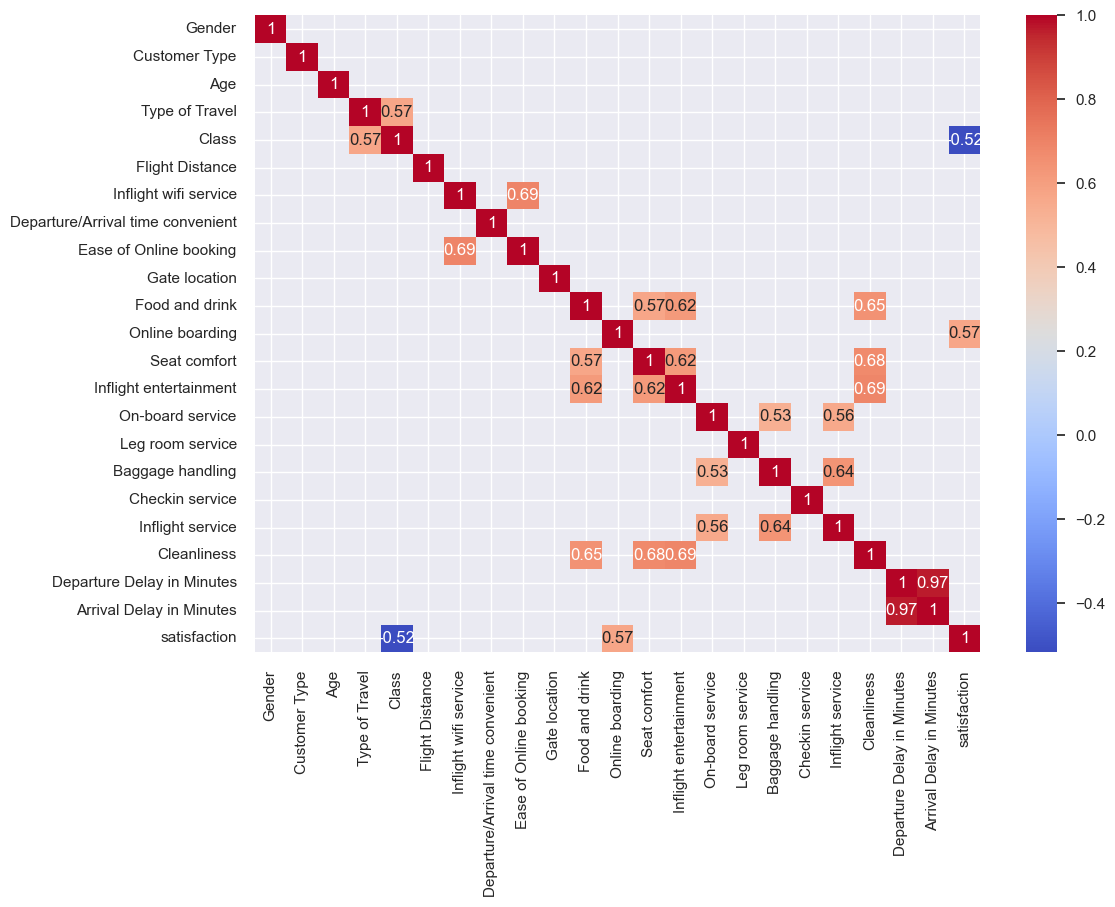

In [32]:
# График корреляций
correlations = features.corr()
threshold = 0.5
high_correlations = correlations[(correlations >= threshold) | (correlations <= -1*threshold)]

sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(high_correlations, annot=True, cmap='coolwarm')
plt.show()

In [33]:
# PCA
features = features.drop(['Arrival Delay in Minutes'], axis=1)

scaler = StandardScaler()
data_scaled = scaler.fit_transform(features)

pca = PCA(n_components=3, random_state=42)
data_pca = pd.DataFrame(
    pca.fit_transform(data_scaled),
    columns=['col1', 'col2', 'col3']
)

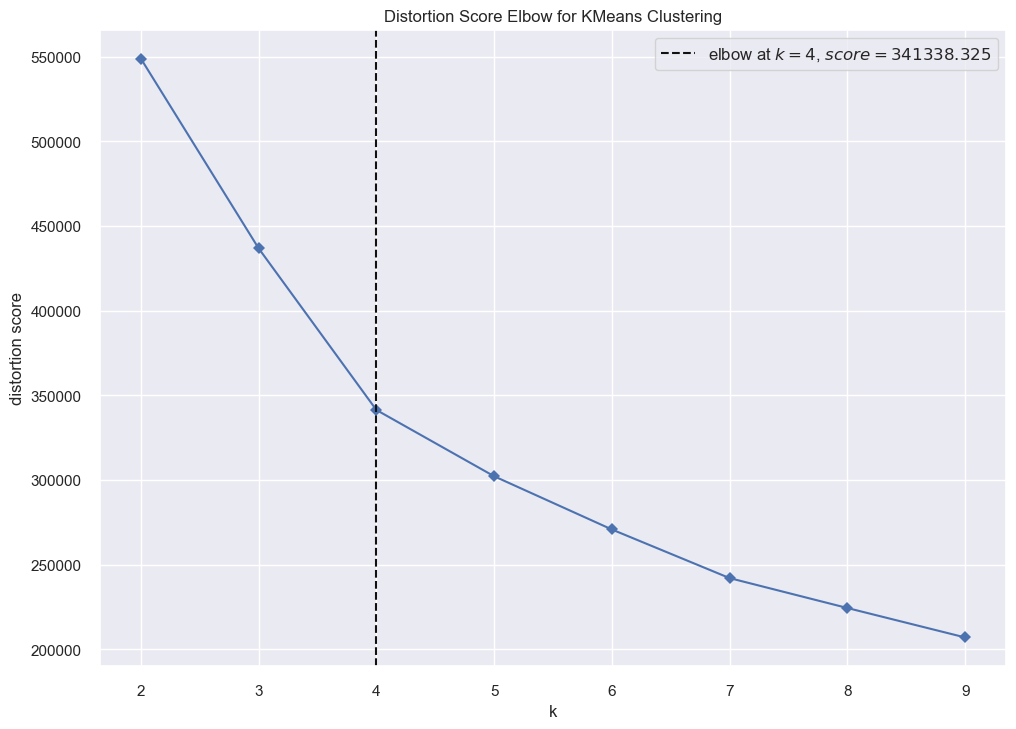

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:
# Метод локтя
elbow = KElbowVisualizer(KMeans(n_init=10), k=(2, 10), timings=False, locate_elbow=True)
elbow.fit(data_pca)
elbow.show()

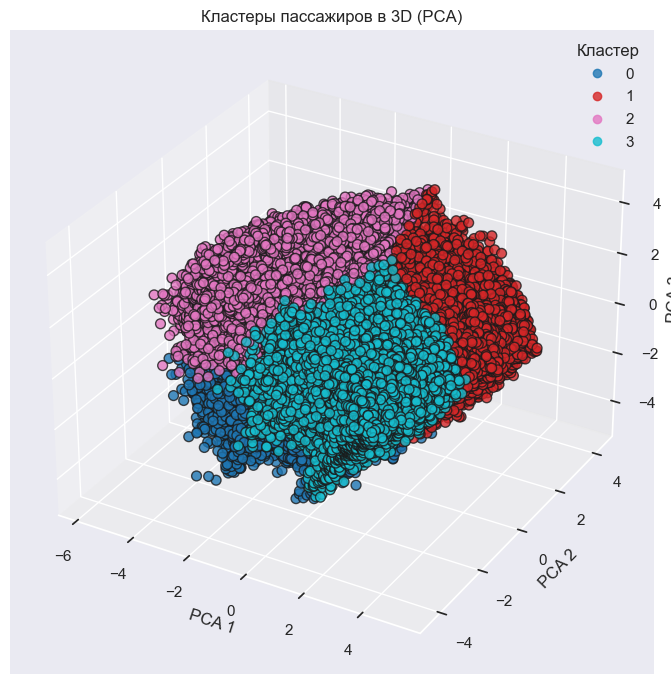

In [35]:
# KMeans (k=4)
model = KMeans(n_clusters=4, random_state=42, n_init=10)
predictions = model.fit_predict(data_pca)

# Возвращаем кластеры и ID
features['Cluster'] = predictions
features['id'] = ids.values

data_pca['Cluster'] = predictions

# 3D график
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    data_pca['col1'],
    data_pca['col2'],
    data_pca['col3'],
    c=data_pca['Cluster'],
    cmap='tab10',
    s=50,
    edgecolor='k',
    alpha=0.8
)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('Кластеры пассажиров в 3D (PCA)')

plt.legend(*scatter.legend_elements(), title="Кластер", loc='best')
plt.tight_layout()
plt.show()

C:\Users\tadzh\AppData\Local\Temp\ipykernel_24932\3969051960.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=features, x='Cluster', palette='Set3', edgecolor='black')


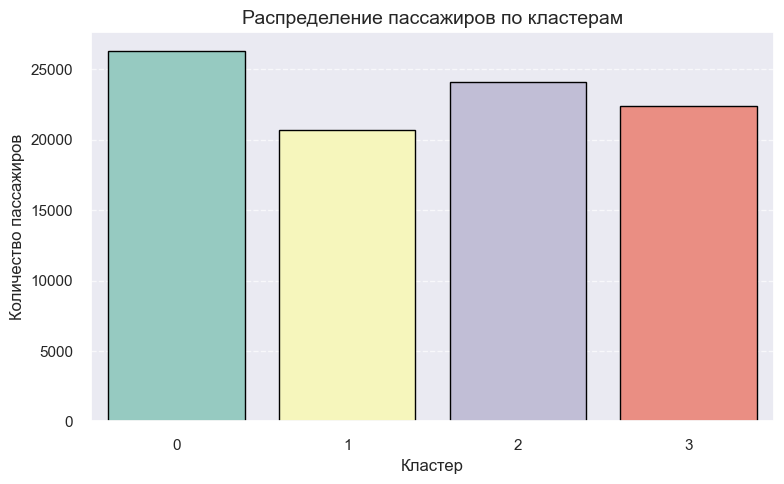

In [36]:
# Распределение по кластерам
plt.figure(figsize=(8, 5))
sns.countplot(data=features, x='Cluster', palette='Set3', edgecolor='black')

plt.title('Распределение пассажиров по кластерам', fontsize=14)
plt.xlabel('Кластер')
plt.ylabel('Количество пассажиров')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [37]:
# Градиентный анализ кластеров
cluster = features.groupby(['Cluster']).mean().T
cluster.style.background_gradient(cmap='RdYlGn', axis=1)


Cluster,0,1,2,3
Gender,0.443165,0.498186,0.543474,0.497278
Customer Type,0.173125,0.115997,0.333430,0.116009
Age,41.367449,42.098292,32.905043,41.867571
Type of Travel,0.417635,0.119044,0.474040,0.141844
Class,0.681217,0.237073,0.757419,0.211226
Flight Distance,1031.333181,1538.794321,847.902677,1558.249197
Inflight wifi service,2.554479,4.306196,2.389126,2.188783
Departure/Arrival time convenient,2.937201,4.197504,3.101349,2.189764
Ease of Online booking,2.649305,4.251004,2.543391,2.115072
Gate location,2.942064,4.062013,2.965636,2.049929


In [38]:
# Сохранение датасета с кластерами
features.to_csv("train_clustered.csv", index=False)

In [39]:
print(features.head())
print(features.columns)

   Gender  Customer Type  Age  Type of Travel  Class  Flight Distance  \
1       1              1   25               0      0              235   
2       0              0   26               0      0             1142   
3       0              0   25               0      0              562   
4       1              0   61               0      0              214   
5       0              0   26               1      1             1180   

   Inflight wifi service  Departure/Arrival time convenient  \
1                      3                                  2   
2                      2                                  2   
3                      2                                  5   
4                      3                                  3   
5                      3                                  4   

   Ease of Online booking  Gate location  ...  On-board service  \
1                       3              3  ...                 1   
2                       2              2  ...   

In [40]:
clustered = pd.read_csv("train_clustered.csv")
priced = pd.read_csv("train_with_price.csv")

# удаляем мусорный индекс если есть
priced = priced.loc[:, ~priced.columns.str.contains('^Unnamed')]

merged = pd.merge(clustered, priced[['id','Price']], on='id')

print(merged.head())


   Gender  Customer Type  Age  Type of Travel  Class  Flight Distance  \
0       1              1   25               0      0              235   
1       0              0   26               0      0             1142   
2       0              0   25               0      0              562   
3       1              0   61               0      0              214   
4       0              0   26               1      1             1180   

   Inflight wifi service  Departure/Arrival time convenient  \
0                      3                                  2   
1                      2                                  2   
2                      2                                  5   
3                      3                                  3   
4                      3                                  4   

   Ease of Online booking  Gate location  ...  Leg room service  \
0                       3              3  ...                 5   
1                       2              2  ...   

In [41]:
merged.to_csv("train_business.csv", index=False)


In [42]:
print("Total revenue:", merged['Price'].sum())


Total revenue: 30921066.200000003


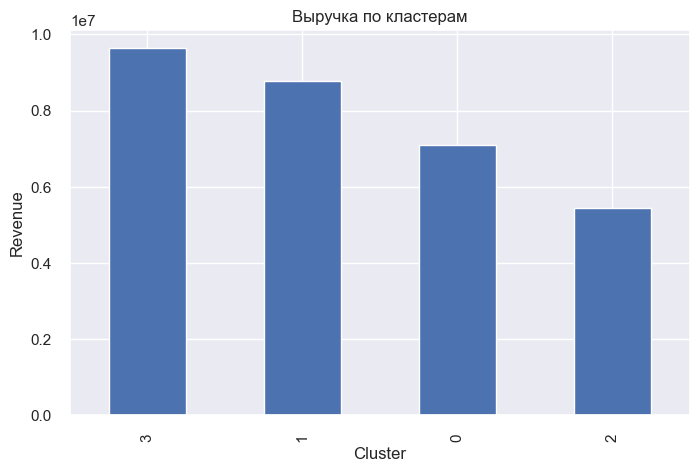

In [43]:
revenue_cluster = merged.groupby('Cluster')['Price'].sum().sort_values(ascending=False)

plt.figure(figsize=(8,5))
revenue_cluster.plot(kind='bar')

plt.title("Выручка по кластерам")
plt.ylabel("Revenue")
plt.xlabel("Cluster")

plt.show()


In [44]:
merged.groupby('Cluster')['Price'].agg(['mean','sum','count'])


,mean,sum,count
Cluster,,,
0,269.263673,7087558.39,26322
1,423.939194,8764094.96,20673
2,225.451079,5432243.74,24095
3,430.000406,9637169.11,22412


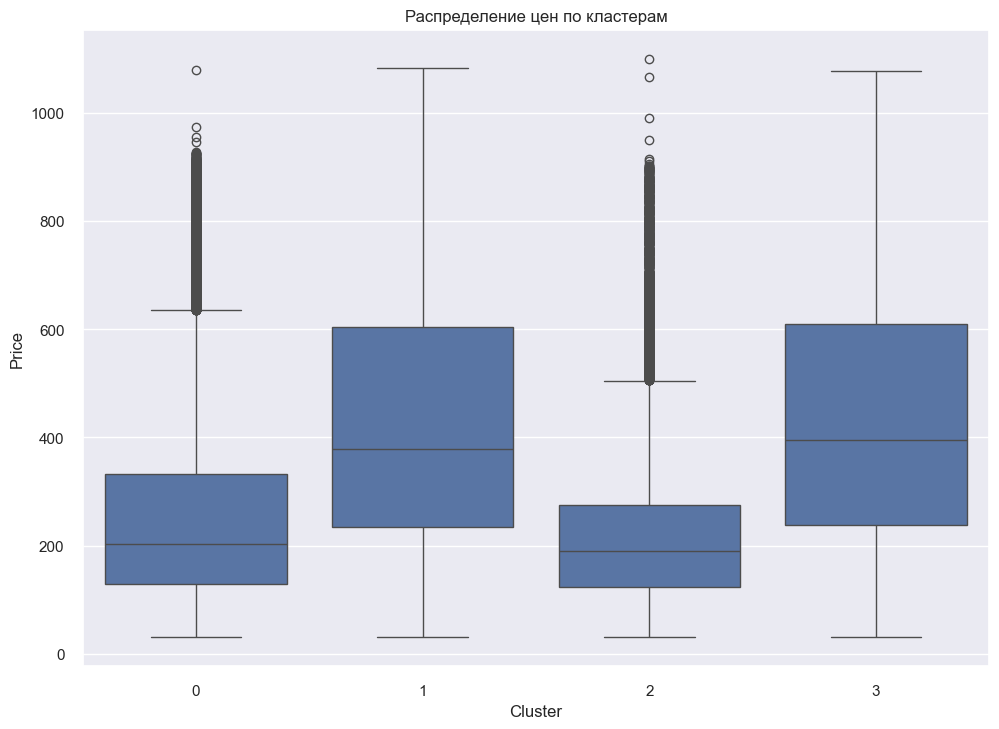

In [45]:
sns.boxplot(data=merged, x='Cluster', y='Price')

plt.title("Распределение цен по кластерам")

plt.show()


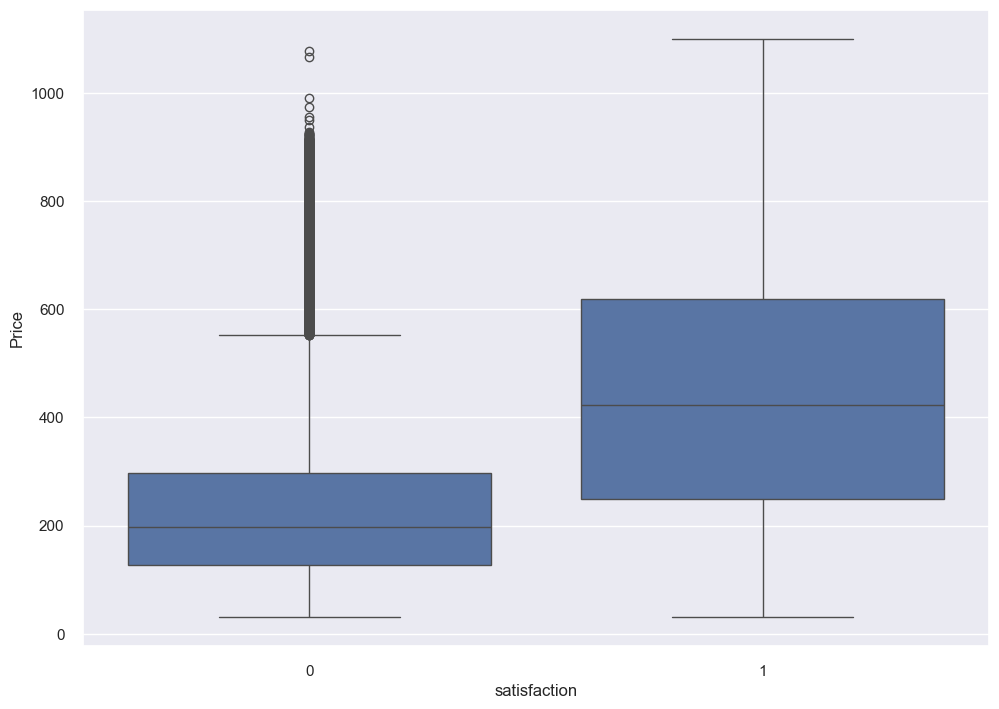

In [46]:
sns.boxplot(data=merged, x='satisfaction', y='Price')
plt.show()


In [48]:
vip = merged[merged['Cluster'] == 1]  # подставишь номер

vip.describe()


,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,Cluster,id,Price
count,20673.000000,20673.000000,20673.000000,20673.000000,20673.000000,20673.000000,20673.000000,20673.000000,20673.000000,20673.000000,...,20673.000000,20673.000000,20673.000000,20673.000000,20673.000000,20673.000000,20673.000000,20673.0,20673.000000,20673.000000
mean,0.498186,0.115997,42.098292,0.119044,0.237073,1538.794321,4.306196,4.197504,4.251004,4.062013,...,3.936052,4.127606,3.694529,4.138103,3.824409,12.918251,0.871233,1.0,66962.458472,423.939194
std,0.500009,0.320229,13.083613,0.323848,0.425297,1115.734325,0.673676,0.966010,0.797470,0.962898,...,1.025117,0.899813,1.111263,0.891369,1.043385,34.465245,0.334950,0.0,37285.775128,229.447274
min,0.000000,0.000000,7.000000,0.000000,0.000000,31.000000,1.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.0,3.000000,30.000000
25%,0.000000,0.000000,33.000000,0.000000,0.000000,551.000000,4.000000,4.000000,4.000000,4.000000,...,3.000000,4.000000,3.000000,4.000000,3.000000,0.000000,1.000000,1.0,35152.000000,235.050000
50%,0.000000,0.000000,43.000000,0.000000,0.000000,1262.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,0.000000,1.000000,1.0,68664.000000,377.870000
75%,1.000000,0.000000,52.000000,0.000000,0.000000,2402.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,10.000000,1.000000,1.0,98788.000000,604.860000
max,1.000000,1.000000,85.000000,1.000000,1.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,933.000000,1.000000,1.0,129863.000000,1084.070000


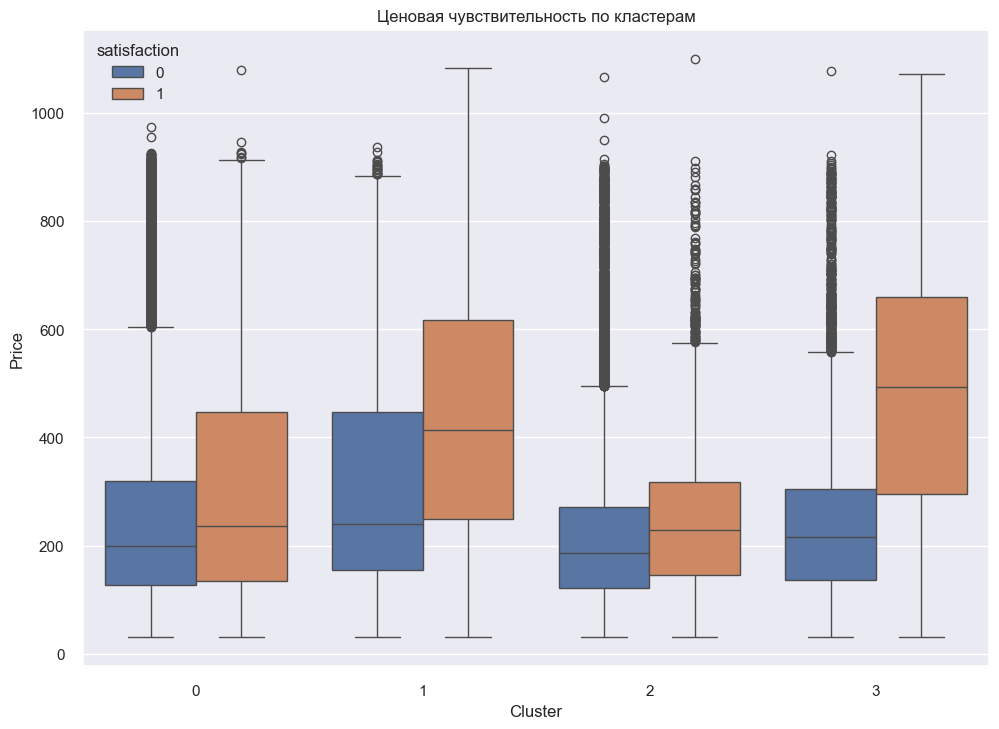

In [50]:
sns.boxplot(data=merged, x='Cluster', y='Price', hue='satisfaction')

plt.title("Ценовая чувствительность по кластерам")

plt.show()



In [51]:
merged[['Price','satisfaction']].corr()


,Price,satisfaction
Price,1.000000,0.431591
satisfaction,0.431591,1.000000


In [52]:
merged.groupby('Cluster').agg({
    'Price':['mean','median'],
    'satisfaction':'mean'
}).round(2)


Price         satisfaction
           mean  median         mean
Cluster                             
0        269.26  202.80         0.14
1        423.94  377.87         0.87
2        225.45  189.17         0.09
3        430.00  395.59         0.74